In [ ]:
import sys
import os

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add it to sys.path if not already added
if project_root not in sys.path:
    sys.path.append(project_root)


In [2]:
# Internal imports
from functions.CPDM import CPDM
from functions.BDT import BDT
from functions.data_generation import DataGeneration
from functions.model_selection import ModelSelection
from functions.predictive_decision_making import PredictiveDecisionMaking

In [3]:
# External imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from skopt.space import Real, Categorical, Integer

from online_cp.CPS import RidgePredictionMachine
from online_cp.CPS import NearestNeighboursPredictionMachine


## Data Generation

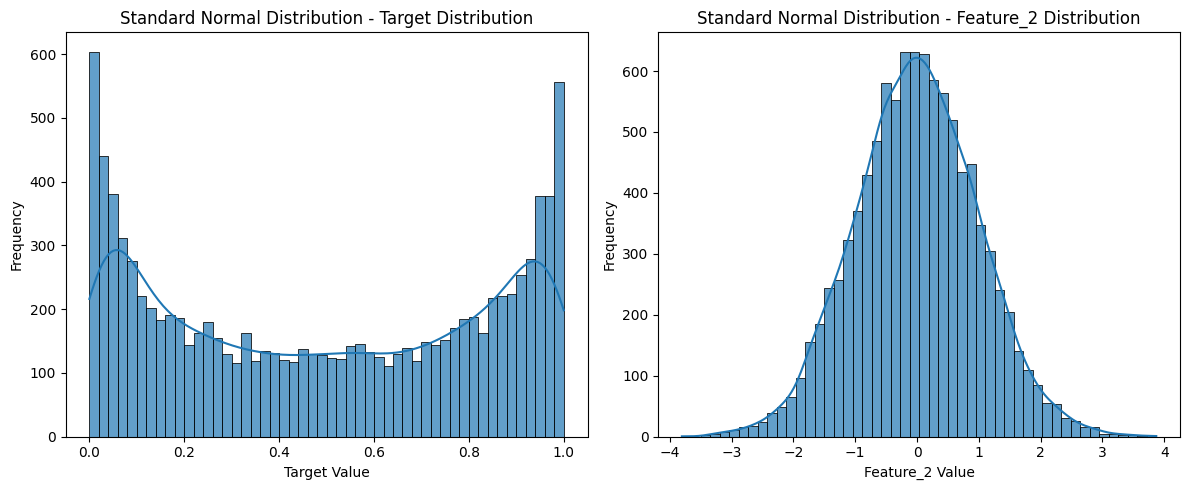

Metrics for Standard Normal Distribution:
Mean: -0.0074
Standard Deviation: 0.9971
Skewness: 0.0206
Kurtosis: 0.1002

--------------------------------------------------



In [4]:
# Set random seed
np.random.seed(2025)

# Create the datasets
df = DataGeneration.create_normal_df(10000, 20)

# Plot the histograms and metrics
DataGeneration.plot_histograms_and_metrics(df, "Standard Normal Distribution")

## Defining the Utility Function

In [5]:
def utility_func(y_value, decision):
    """
    Maps y_value to a utility score for a given decision.
    """
    y_value = int(round(y_value))
    if decision:
        if y_value:
            return 5
        else:
            return -2
    else:
        if y_value:
            return -2
        else:
            return 0

## Experiment pipeline with standard normal distribution

PRELIMINARIES

- Create the train and test subsets 100 samples

- Define the models

- Model selection

- Optimal Decision Making



INDUCTIVE METHODS

- Inductive Predictive Decision Making

- Inductive Conformal Predictive Decision Making

- Inductive Bayesian Decision Theory



ONLINE METHODS

- Online Predictive Decision Making

- Online Conformal Predictive Decision Making

- Online Bayesian Decision Theory


## Preliminaries

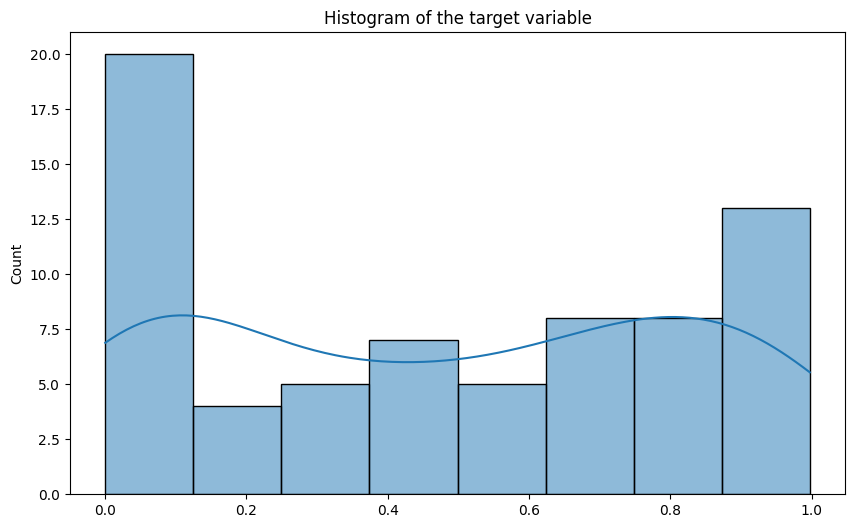

Train set size: 70
Test set size: 15
Calibration set size: 15


In [6]:
# Create the train and test subsets 100 samples
subset = df.sample(n=100, random_state=2025) 

# Separate features (X) and target (y)
y = subset["Target"]  # Select the target column
X = subset.drop("Target", axis=1)  # Drop the target column to get features

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2025)

X_cal, X_test, y_cal, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2025)

# Combine training and calibration sets
X_train_full, y_train_full = map(lambda df: df.to_numpy(), [pd.concat([X_train, X_cal]), pd.concat([y_train, y_cal])])

# Convert all subsets to NumPy arrays
X_train, y_train, X_test, y_test, X_cal, y_cal = map(
    lambda df: df.to_numpy(), [X_train, y_train, X_test, y_test, X_cal, y_cal]
)

# Histogram of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True)
plt.title("Histogram of the target variable")
plt.show()

print(f"Train set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")
print(f"Calibration set size: {len(y_cal)}")


## Model selection (inductive)

### KNN - Inductive CPDM

In [7]:
### Model definition selection

knn = KNeighborsRegressor(n_jobs=-1)

knn_search_space = {
    'n_neighbors': Integer(1, 20),
    'weights': Categorical(['uniform', 'distance']),
    'p': Integer(1, 2)
}

best_params_knn, best_score_knn = ModelSelection.bayesian_model_selection(X_train, y_train, knn, knn_search_space)

ModelSelection.print_cv_results(str(best_params_knn), best_score_knn)

/Users/simon/Documents/GitHub/Conformal-Predictive-Decision-Making/.venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(1), np.int64(1), np.str_('uniform')] before, using random point [np.int64(6), np.int64(1), 'distance']
  warnings.warn(
/Users/simon/Documents/GitHub/Conformal-Predictive-Decision-Making/.venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(17), np.int64(2), np.str_('uniform')] before, using random point [np.int64(7), np.int64(1), 'distance']
  warnings.warn(
/Users/simon/Documents/GitHub/Conformal-Predictive-Decision-Making/.venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(1), np.str_('distance')] before, using random point [np.int64(12), np.int64(1), 'uniform']
  warnings.warn(
/Users/simon/Documents/GitHub/Confo

Best Parameters: OrderedDict([('n_neighbors', 5), ('p', 1), ('weights', 'uniform')])
Best CV Score: -0.067


### Ridge regression - Inductive CPDM

In [8]:
ridge = Ridge()

ridge_search_space = {
    'alpha': Real(1e-4, 1e+4, prior='log-uniform')
}

best_params_ridge, best_score_ridge = ModelSelection.bayesian_model_selection(X_train, y_train, ridge, ridge_search_space)

ModelSelection.print_cv_results(str(best_params_ridge), best_score_ridge)

Best Parameters: OrderedDict([('alpha', 5.261028477953844)])
Best CV Score: -0.023


### Model training - Inductive CPDM

In [9]:
selected_knn = KNeighborsRegressor(
    n_neighbors=best_params_knn['n_neighbors'],
    weights=best_params_knn['weights'],
    p=best_params_knn['p'],
    n_jobs=-1
)
selected_ridge = Ridge(
    alpha=best_params_ridge['alpha']
)

models = [
    selected_knn,
    selected_ridge
]

for model in models:
    test_score = ModelSelection.evaluate(X_train, y_train, X_test, y_test, model, mean_squared_error)
    print(f"{model.__class__.__name__}: Test Score (MSE): {test_score:.3f}")

KNeighborsRegressor: Test Score (MSE): 0.074
Ridge: Test Score (MSE): 0.021


### Bayesian Ridge - BDT (inductive and online)

In [10]:
bayes_ridge = BayesianRidge()

bayes_ridge_search_space = {
    'alpha_1': Real(1e-6, 1e-2, prior='log-uniform'),
    'alpha_2': Real(1e-6, 1e-2, prior='log-uniform'),
    'lambda_1': Real(1e-6, 1e-2, prior='log-uniform'),
    'lambda_2': Real(1e-6, 1e-2, prior='log-uniform')
}

best_params_bayes_ridge, best_score_bayes_ridge = ModelSelection.bayesian_model_selection(X_train_full, y_train_full, bayes_ridge, bayes_ridge_search_space)

ModelSelection.print_cv_results(str(best_params_bayes_ridge), best_score_bayes_ridge)

Best Parameters: OrderedDict([('alpha_1', 0.0003119298729543006), ('alpha_2', 0.009930561480809093), ('lambda_1', 0.001282050089790495), ('lambda_2', 0.0022840483146290055)])
Best CV Score: -0.022


In [11]:
# GP with standard kernel settings
gp = GaussianProcessRegressor(kernel=C(1.0) * RBF(length_scale=1.0), alpha=1e-3, normalize_y=True)

# Fit the GP
gp.fit(X_train_full, y_train_full)

# Obtain optimal kernel parameters
print(gp.kernel_)

1.45**2 * RBF(length_scale=6.98)


In [12]:
selected_bayes_ridge = BayesianRidge(
    alpha_1=best_params_bayes_ridge['alpha_1'],
    alpha_2=best_params_bayes_ridge['alpha_2'],
    lambda_1=best_params_bayes_ridge['lambda_1'],
    lambda_2=best_params_bayes_ridge['lambda_2']
)

selected_gp = gp

bayesian_models = [
    selected_bayes_ridge,
    selected_gp
]

for model in bayesian_models:
    test_score = ModelSelection.evaluate(X_train_full, y_train_full, X_test, y_test, model, mean_squared_error)
    print(f"{model.__class__.__name__}: Test Score (MSE): {test_score:.3f}")

BayesianRidge: Test Score (MSE): 0.021
GaussianProcessRegressor: Test Score (MSE): 0.020


## Optimal decision making

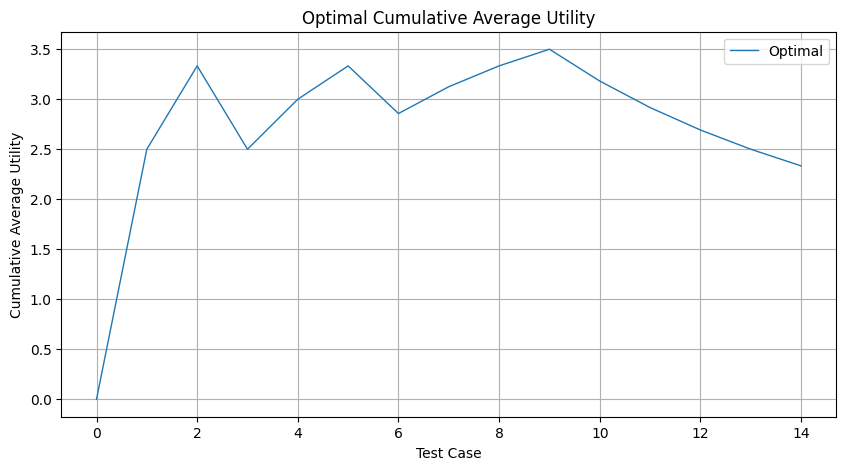

In [13]:
Decisions = {0, 1}
_, optimal_average_utility = CPDM.optimal_decision_making(Decisions, y_test, utility_func)

plt.figure(figsize=(10, 5))
plt.plot(optimal_average_utility, linewidth=1, label="Optimal")
plt.xlabel("Test Case")
plt.ylabel("Cumulative Average Utility")
plt.title("Optimal Cumulative Average Utility")
plt.legend()
plt.grid(True)
plt.show()

## CPDM (inductive and online)

In [14]:
average_utilities = {}
threshold = 0.5
for model in models:
    _, average_utility = CPDM.inductive_CPDM(
        Decisions,
        X_train,
        y_train,
        X_cal,
        y_cal,
        X_test,
        y_test,
        utility_func,
        model,
    )

    _, inductive_p_average_utility = (
        PredictiveDecisionMaking.inductive_predictive_decision_making(
            X_train_full,
            y_train_full,
            X_test,
            y_test,
            utility_func,
            model,
            threshold,
        )
    )
    
    if isinstance(model, KNeighborsRegressor):
        cps_knn = NearestNeighboursPredictionMachine(k = 5)
        _, online_average_utility, _ = (
            CPDM.online_CPDM(
                Decisions,
                X_train,
                y_train,
                X_test,
                y_test,
                utility_func,
                threshold,
                cps_knn,
            )
        )
    else:
        cps_ridge = RidgePredictionMachine(autotune=True)
        _, online_average_utility, _ = (
            CPDM.online_CPDM(
                Decisions,
                X_train,
                y_train,
                X_test,
                y_test,
                utility_func,
                threshold,
                cps_ridge,
            )
        )
    
    _, online_p_average_utility = (
        PredictiveDecisionMaking.online_predictive_decision_making(
            X_train_full,
            y_train_full,
            X_test,
            y_test,
            utility_func,
            model,
            threshold,
        )
    )
    
    average_utilities[model.__class__.__name__] = {
        "optimal_average_utility": optimal_average_utility,
        "inductive_average_utility": average_utility,
        "inductive_p_average_utility": inductive_p_average_utility,
        "online_average_utility": online_average_utility,
        "online_p_average_utility": online_p_average_utility,
    }


Running online conformal prediction:   0%|          | 0/15 [00:00<?, ?it/s]

Running online conformal prediction:   0%|          | 0/15 [00:00<?, ?it/s]

Running online conformal prediction:   0%|          | 0/15 [00:00<?, ?it/s]

Running online conformal prediction:   0%|          | 0/15 [00:00<?, ?it/s]

In [15]:
print(average_utilities["KNeighborsRegressor"])

{'optimal_average_utility': [0.0, 2.5, 3.3333333333333335, 2.5, 3.0, 3.3333333333333335, 2.857142857142857, 3.125, 3.3333333333333335, 3.5, 3.1818181818181817, 2.9166666666666665, 2.6923076923076925, 2.5, 2.3333333333333335], 'inductive_average_utility': [-2.0, 1.5, 2.6666666666666665, 1.5, 2.2, 2.6666666666666665, 2.0, 2.375, 2.6666666666666665, 2.9, 2.4545454545454546, 2.0833333333333335, 1.7692307692307692, 1.5, 1.2666666666666666], 'inductive_p_average_utility': array([0.        , 2.5       , 1.        , 0.75      , 1.6       ,
       2.16666667, 1.57142857, 1.125     , 1.55555556, 1.9       ,
       1.72727273, 1.58333333, 1.46153846, 1.35714286, 1.26666667]), 'online_average_utility': [-2.0, 1.5, 2.6666666666666665, 2.0, 2.6, 3.0, 2.2857142857142856, 2.625, 2.888888888888889, 3.1, 2.6363636363636362, 2.25, 1.9230769230769231, 1.6428571428571428, 1.4], 'online_p_average_utility': array([0.        , 2.5       , 1.        , 0.75      , 1.6       ,
       2.16666667, 1.57142857, 1.12

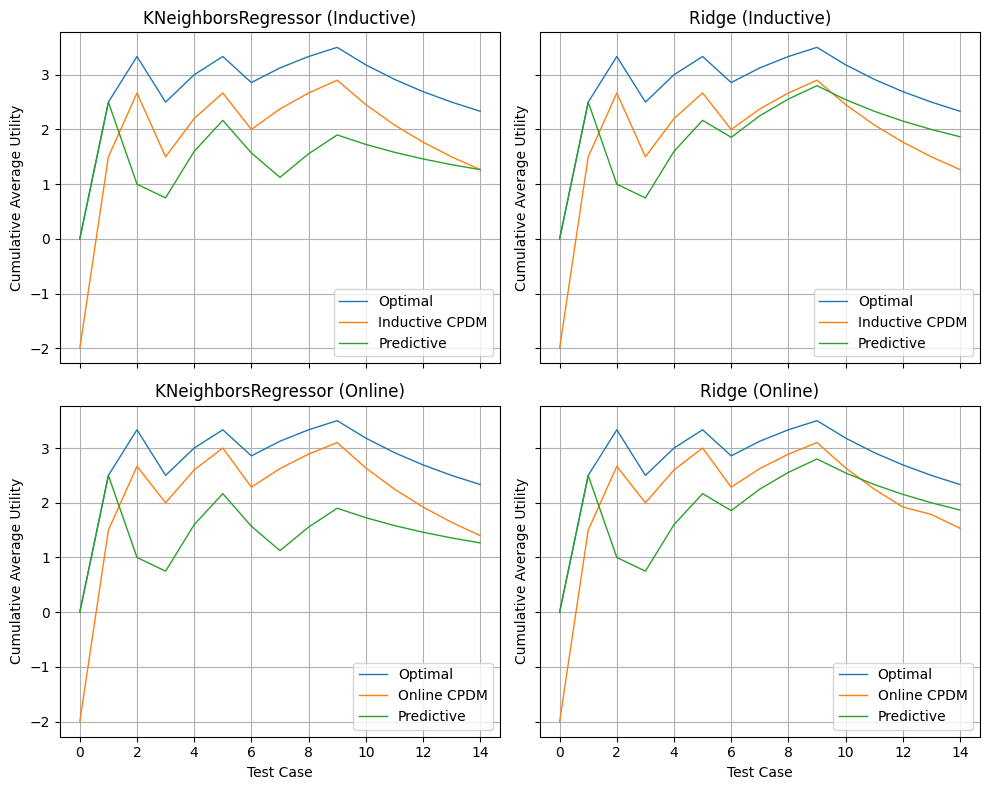

In [21]:
n_models = len(models)

# Create the figure
fig, axes = plt.subplots(2, n_models, figsize=(5 * n_models, 8), sharex=True, sharey=True)

for i, (model, results) in enumerate(average_utilities.items()):
    # Inductive (Top Row)
    axes[0, i].plot(results["optimal_average_utility"], linewidth=1, label="Optimal")
    axes[0, i].plot(results["inductive_average_utility"], linewidth=1, label="Inductive CPDM")
    axes[0, i].plot(results["inductive_p_average_utility"], linewidth=1, label="Predictive")
    axes[0, i].legend()
    axes[0, i].set_title(f"{model} (Inductive)")
    axes[0, i].set_ylabel("Cumulative Average Utility")
    axes[0, i].grid(True)
    
    # Online (Bottom Row)
    axes[1, i].plot(results["optimal_average_utility"], linewidth=1, label="Optimal")
    axes[1, i].plot(results["online_average_utility"], linewidth=1, label="Online CPDM")
    axes[1, i].plot(results["online_p_average_utility"], linewidth=1, label="Predictive")
    axes[1, i].legend()
    axes[1, i].set_title(f"{model} (Online)")
    axes[1, i].set_xlabel("Test Case")
    axes[1, i].set_ylabel("Cumulative Average Utility")
    axes[1, i].grid(True)

# Remove empty subplots if n_models is odd
for k in range(i + 1, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()


## BDT (inductive and online)

In [17]:
bayesian_average_utilities = {}
for model in bayesian_models:
    # Inductive
    _, inductive_average_utility = BDT.inductive_BDT(
        Decisions,
        X_train_full,
        y_train_full,
        X_test,
        y_test,
        utility_func,
        model,
    )
    _, inductive_p_average_utility = (
        PredictiveDecisionMaking.inductive_predictive_decision_making(
            X_train_full,
            y_train_full,
            X_test,
            y_test,
            utility_func,
            model,
            threshold,
        )
    )
    
    # Online
    _, online_average_utility = BDT.online_BDT(
        Decisions,
        X_train_full,
        y_train_full,
        X_test,
        y_test,
        utility_func,
        model,
    )
    
    _, online_p_average_utility = (
        PredictiveDecisionMaking.online_predictive_decision_making(
            X_train_full,
            y_train_full,
            X_test,
            y_test,
            utility_func,
            model,
            threshold,
        )
    )
    
    bayesian_average_utilities[model.__class__.__name__] = {
        "optimal_average_utility": optimal_average_utility,
        "inductive_bayesian_average_utility": average_utility,
        "inductive_p_average_utility": inductive_p_average_utility,
        "online_bayesian_average_utility": online_average_utility,
        "online_p_average_utility": online_p_average_utility,
    }


Processing Samples:   0%|          | 0/15 [00:00<?, ?it/s]

Processing Samples:   0%|          | 0/15 [00:00<?, ?it/s]

Processing Samples:   0%|          | 0/15 [00:00<?, ?it/s]

Processing Samples:   0%|          | 0/15 [00:00<?, ?it/s]

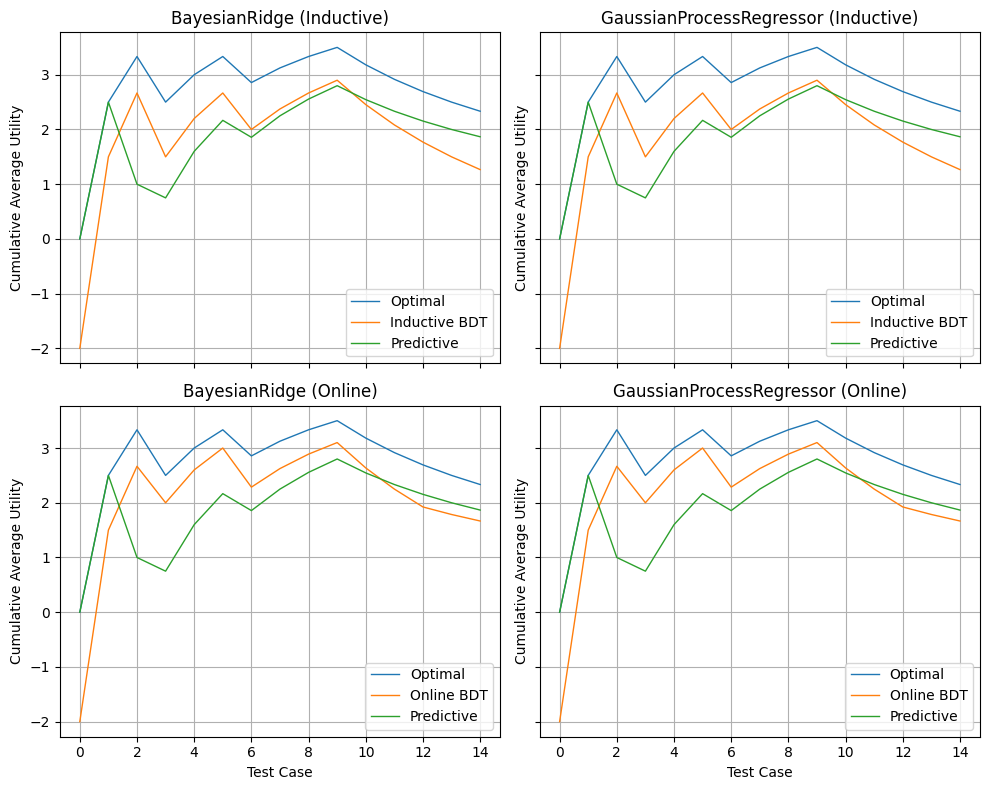

In [22]:
# Define number of models
n_models = len(bayesian_average_utilities)

# Create the figure with 2 rows (Inductive on top, Online on bottom)
fig, axes = plt.subplots(2, n_models, figsize=(5 * n_models, 8), sharex=True, sharey=True)

# If only one model exists, make sure axes is iterable
if n_models == 1:
    axes = np.array([[axes[0]], [axes[1]]])  # Ensure it's a 2D array for consistency

for i, (model, results) in enumerate(bayesian_average_utilities.items()):
    # Inductive (Top Row)
    ax_inductive = axes[0, i]
    ax_inductive.plot(results["optimal_average_utility"], linewidth=1, label="Optimal")
    ax_inductive.plot(results["inductive_bayesian_average_utility"], linewidth=1, label="Inductive BDT")
    ax_inductive.plot(results["inductive_p_average_utility"], linewidth=1, label="Predictive")
    ax_inductive.legend()
    ax_inductive.set_title(f"{model} (Inductive)")
    ax_inductive.set_ylabel("Cumulative Average Utility")
    ax_inductive.grid(True)

    # Online (Bottom Row)
    ax_online = axes[1, i]
    ax_online.plot(results["optimal_average_utility"], linewidth=1, label="Optimal")
    ax_online.plot(results["online_bayesian_average_utility"], linewidth=1, label="Online BDT")
    ax_online.plot(results["online_p_average_utility"], linewidth=1, label="Predictive")
    ax_online.legend()
    ax_online.set_title(f"{model} (Online)")
    ax_online.set_xlabel("Test Case")
    ax_online.set_ylabel("Cumulative Average Utility")
    ax_online.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()